In [1]:
from matplotlib import pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from collections import Counter
from sklearn import ensemble
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns

import spacy

sns.set(rc={'figure.figsize':(12,7)}, style='whitegrid', color_codes=True)

/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Source = http://jmcauley.ucsd.edu/data/amazon/ 

## Challenge: Is to Build an NLP model to classify reviews or texts from Amazon as positive or negative.

In [2]:
#df =  pd.read_csv('/Users/Sri/Downloads/Amazon_Books_Review.csv')
df = pd.read_json('Amazon_Instant_Video_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400


In [4]:
df.overall.value_counts(normalize=True)

5    0.562678
4    0.227496
3    0.112778
2    0.050773
1    0.046275
Name: overall, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.8+ MB


In [6]:
# Making a subset dataframe of only the columns which are necessary for analysis.
data=df[['reviewText', 'overall']]

In [7]:
# Making a subset of the data for faster run time
data = data.sample(frac=0.05, replace=False, random_state=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856 entries, 19223 to 33133
Data columns (total 2 columns):
reviewText    1856 non-null object
overall       1856 non-null int64
dtypes: int64(1), object(1)
memory usage: 43.5+ KB


In [9]:
data.head()

,reviewText,overall
19223,i saw the series on TV and wasn;t too imressed...,5
8564,I love police procedurals. My favorite is the ...,5
10406,"Very good well written series, so sorry it di...",3
14717,"One episode in, I plan to watch another. The a...",3
2554,"This is a wild ride, on the one hand we've got...",5


In [10]:
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [11]:
# Deleting the null values since they represent 0.006% of the data.
data.dropna(inplace=True, axis=0)
data.reset_index(inplace=True, drop=True)

In [12]:
data.overall.unique()

array([5, 3, 4, 2, 1])

In [13]:
# Creating outcome variable i.e review_sentiment as positive or negative
data['review_sentiment'] = np.where(data['overall'] > 3, 1, 0)

In [14]:
data.head()

,reviewText,overall,review_sentiment
0,i saw the series on TV and wasn;t too imressed...,5,1
1,I love police procedurals. My favorite is the ...,5,1
2,"Very good well written series, so sorry it di...",3,0
3,"One episode in, I plan to watch another. The a...",3,0
4,"This is a wild ride, on the one hand we've got...",5,1


Before doing any of the next steps we need to extract the revies as positive or negative for creating features category wise.

In [15]:
all_reviews_positive=[]
all_reviews_negative=[]

for text in (data.loc[data['review_sentiment'] == 1, 'reviewText'].values):
    all_reviews_positive.append(text)
    
for text in (data.loc[data['review_sentiment'] == 0, 'reviewText'].values):
    all_reviews_negative.append(text)

In [16]:
all_reviews_positive[2]

'This is a wild ride, on the one hand we\'ve got this incredibly hyper violent bike gang made up of some really good guys. Seriously who would NOT want to go out for a beer with jackson, Opie, Chips, Scotty, Juice or Bobby Elvis?? Clay is another matter. Then there is the comparative morality of corrupt politicians, cynical, venal government agencies and morally compromised businessmen. So they get into all of these wild escapades, nothing is ever what it seems and the SOA is always about 15 minutes from death, destruction and prison as one scheme after another backfires. Someone should make a reel of the many "oh s***" moments in the series, whenever someone says it, it has already hit the fan. But it is never boring. I guarantee that if you buy the series you will be up all night watching it, simply to see what happens next. Highest possible rating.'

In [17]:
len(all_reviews_positive)

1480

In [18]:
len(all_reviews_negative)

376

In [19]:
# Finding the length of each review for 10 rows
for i in range(10):
    print (len (data['reviewText'][i]))

341
413
110
169
861
237
505
277
1462
111


Some of them have pretty long reviews. More the words better it is for word training.

Since the size of the text is greater than 1 million, Spacy gives an error. so broken down the text into a list of strings.

In [20]:
# Parsing the texts
nlp = spacy.load('en')

all_reviews_positive_list_doc = [ nlp(text) for text in all_reviews_positive]
all_reviews_negative_list_doc = [ nlp(text) for text in all_reviews_negative]

In [21]:
all_reviews_positive_list_doc[:1]

[i saw the series on TV and wasn;t too imressed. The second time around was much, much better!The story line moves effortlessly, the characters are intriguing and the suspense is superb.I highly recommend this series to all who would enjoy horror with a great story line.Also see the first American Horror Story...that is really,really good!!]

### 1. Data cleaning / processing / language parsing

In [22]:
# Cleaning the texts and making the words ready for further processing

all_reviews_list_cleaned_doc=[]
temp=''         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and  token.is_alpha:
            temp = temp + ' ' + token.text.lower()
    all_reviews_list_cleaned_doc.append(temp)
    temp=''

In [23]:
all_reviews_list_cleaned_doc[0]

' i saw the series on tv and too imressed the second time around was much much story line moves effortlessly the characters are intriguing and the suspense is superb i highly recommend this series to all who would enjoy horror with a great story line also see the first american horror story that is really really good'

### 2. Create features using two different NLP methods: For example,  tf-idf and word2vec.

### TF-IDF

In [24]:
def tf_idf_svd_normalizer(doc):
    from sklearn.feature_extraction.text import TfidfVectorizer


    vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
    #Applying the vectorizer
    review_tfidf=vectorizer.fit_transform(doc)
    print("Number of features: %d" % review_tfidf.get_shape()[1])

    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer

    #Our SVD data reducer.  We are going to reduce the feature space.
    svd= TruncatedSVD(80)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD.
    review_lsa = lsa.fit_transform(review_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("\nPercent variance captured by all components:",total_variance*100)
    reviews_by_component=pd.DataFrame(review_lsa, index=doc)

    return reviews_by_component

In [25]:
reviews_by_component = tf_idf_svd_normalizer(all_reviews_list_cleaned_doc)

Number of features: 6202

Percent variance captured by all components: 22.81801015279512


In [26]:
#Adding review sentiment to the final dataframe with tfidf values
reviews_by_component.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

reviews_by_component['review_sentiment'] = 0
reviews_by_component.loc[0:len(all_reviews_positive_list_doc)-1, 'review_sentiment'] = 1

In [27]:
reviews_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,review_sentiment
0,0.409386,-0.167504,0.149653,-0.297478,0.067441,-0.093546,-0.349690,-0.078720,-0.196179,-0.115315,...,-0.005235,0.054369,0.023314,0.066395,0.176111,-0.030651,0.037291,0.006997,0.026691,1
1,0.321145,-0.044752,0.223515,0.014327,0.005456,0.115179,-0.079633,-0.047113,0.095964,0.056035,...,-0.100696,-0.170465,-0.058358,-0.116201,-0.040448,0.008757,-0.000471,0.024744,-0.045492,1
2,0.417521,-0.146403,-0.030087,-0.144196,-0.114588,-0.201507,0.116010,0.101960,0.100897,0.118997,...,-0.088107,0.042858,0.086857,-0.067961,-0.226714,0.015309,0.182233,0.173081,-0.215865,1
3,0.431610,0.130480,-0.123727,-0.058555,-0.222982,-0.026201,0.075022,-0.002397,0.203415,0.030632,...,-0.003971,0.088073,0.014646,-0.010094,0.084340,0.037972,0.016298,0.035692,0.035740,1
4,0.364417,-0.253571,-0.050427,0.251455,0.270324,-0.010629,-0.151657,0.173579,0.163715,0.116325,...,-0.284332,-0.028360,0.021132,0.099091,0.049784,-0.154065,-0.008398,0.014875,0.147180,1


In [28]:
# To schuffle samples

for i in range(10):
    reviews_by_component = reviews_by_component.sample(frac=1, replace=False, random_state=2)
reviews_by_component.reset_index(drop=True, inplace=True)

# Splitting data into X and Y
Y = reviews_by_component['review_sentiment']
X = reviews_by_component.loc[:, ~(reviews_by_component.columns).isin(['review_sentiment'])]

In [29]:
reviews_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,review_sentiment
0,0.393883,-0.063567,0.257261,-0.431183,-0.185275,-0.128605,-0.096146,0.158496,0.039335,0.090518,...,0.012684,-0.021070,-0.025396,0.098054,0.056963,0.006953,-0.064504,0.069662,-0.000399,1
1,0.239320,-0.129531,-0.029673,0.044872,-0.111814,0.069430,0.047863,-0.069548,0.071067,0.007624,...,-0.096269,0.097561,-0.174365,0.040121,0.054634,-0.092704,-0.136287,0.136612,-0.002873,1
2,0.190900,-0.034120,0.041958,0.054853,-0.099733,0.023326,0.328086,-0.123576,-0.165648,0.051635,...,0.029715,0.122833,0.012946,-0.075059,-0.071037,0.012516,0.056669,-0.054625,-0.114511,1
3,0.183180,-0.075942,-0.004258,-0.010940,0.008600,0.023648,-0.059022,-0.023905,-0.043008,0.101852,...,0.033308,0.004526,-0.053670,-0.003920,-0.075444,0.017720,-0.055234,-0.114543,0.109898,0
4,0.175584,-0.148213,-0.009032,-0.002570,-0.146987,0.029949,-0.119006,-0.129979,-0.016633,0.010882,...,0.137767,-0.072883,-0.086036,0.117234,0.104424,-0.226226,-0.177069,0.039526,0.149986,1


In [30]:
np.array(Y.T)

array([1, 1, 1, ..., 0, 1, 1])

In [31]:
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 1480, 0: 376})


There is a lot of class imbalance here. Need to correct the problem before going further by over sampling and under sampling (SMOTE).

In [32]:
# SMOTE i.e oversampling and undersampling
smote = SMOTE(random_state=1)
X, Y = smote.fit_resample(X, Y)
print('Number of review samples per each class\n {}'.format(Counter(Y)))

Number of review samples per each class
 Counter({1: 1480, 0: 1480})


In [33]:
Y

array([1, 1, 1, ..., 0, 0, 0])

Smote does minority oversampling...but adds them all together at the end causing a non-randomness in the samples.
Need to shuffle again

In [34]:
#Shuffle again 
X = pd.DataFrame(X)
Y = pd.DataFrame(Y,columns=['sentiment'])

for i in range(10):
    X = X.sample(frac=1, replace=False, random_state=2)
    Y = Y.sample(frac=1, replace=False, random_state=2)
X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)
Y = Y['sentiment']

In [35]:
print('Number of review samples per each class\n {}'.format(Counter(np.array(Y))))

Number of review samples per each class
 Counter({1: 1480, 0: 1480})


In [36]:
np.array(Y)

array([1, 0, 0, ..., 1, 1, 1])

### 3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
### 4. Assess your models using cross-validation and determine whether one model performed better.

In [37]:
def model(mod, X=X, Y=Y):
    model_object=mod
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=3)
    model_object.fit(X_train, y_train)
    print ("Model train score is %0.2f" % (model_object.score(X_train, y_train)) )
    evaluation(model_object)
    return model_object

def evaluation(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print ('\nCross_validation scores below :\n', score)
    print("\nMean/test accuracy: %0.2f (+/- %0.2f)\n" % (score.mean(), score.std() * 2))
    
    y_pred=model_object.predict(X_test)
  
   #Plotting the ROC-AUC curve   
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', linewidth=4,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fancybox=True, fontsize='large')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    fpr=fpr[1]
    tpr=tpr[1]
    print ('The sensitivity i.e true positives is {0:2f}% '.format(tpr*100))
    print ('The specificity i.e true negatives is {0:2f}% '.format((1-fpr)*100))
    print ('The Type I error i.e. false negatives is {0:2f}% '.format((1-tpr)*100))
    print ('The Type II error i.e. false positives is {0:2f}% '.format(fpr*100))
    return

In [38]:
### Naive Bayes Classifier

Model train score is 0.73

Cross_validation scores below :
 [0.69333333 0.74666667 0.66666667 0.62162162 0.67567568 0.7027027
 0.74324324 0.7260274  0.67123288 0.7260274 ]

Mean/test accuracy: 0.70 (+/- 0.07)



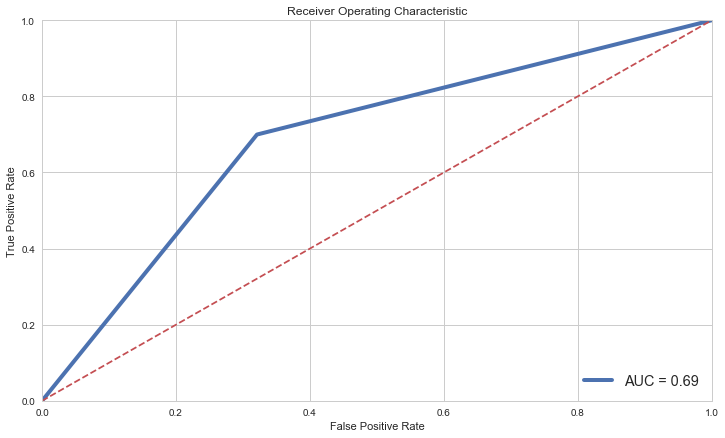

The sensitivity i.e true positives is 69.972452% 
The specificity i.e true negatives is 67.904509% 
The Type I error i.e. false negatives is 30.027548% 
The Type II error i.e. false positives is 32.095491% 


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [39]:
model(BernoulliNB())

In [40]:
### kNN Classifier

Model train score is 0.77

Cross_validation scores below :
 [0.58666667 0.68       0.62666667 0.67567568 0.59459459 0.7027027
 0.7027027  0.63013699 0.65753425 0.67123288]

Mean/test accuracy: 0.65 (+/- 0.08)



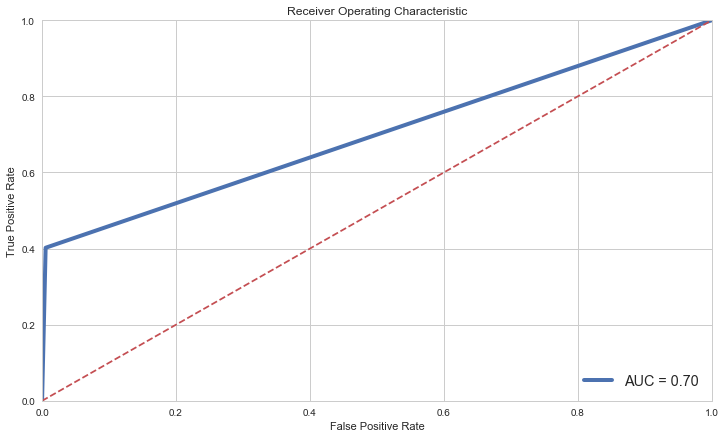

The sensitivity i.e true positives is 40.220386% 
The specificity i.e true negatives is 99.469496% 
The Type I error i.e. false negatives is 59.779614% 
The Type II error i.e. false positives is 0.530504% 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [41]:
model(neighbors.KNeighborsClassifier(n_neighbors=5))

In [42]:
### Random Forest Classifier

Model train score is 0.99


/Users/Sri/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Cross_validation scores below :
 [0.77333333 0.85333333 0.70666667 0.72972973 0.74324324 0.82432432
 0.7027027  0.78082192 0.73972603 0.7260274 ]

Mean/test accuracy: 0.76 (+/- 0.09)



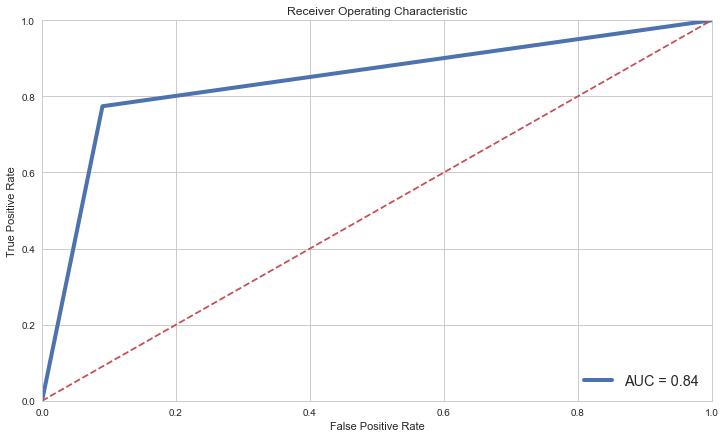

The sensitivity i.e true positives is 77.410468% 
The specificity i.e true negatives is 90.981432% 
The Type I error i.e. false negatives is 22.589532% 
The Type II error i.e. false positives is 9.018568% 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
model(ensemble.RandomForestClassifier())

In [44]:
### Logistic Regression

Model train score is 0.80

Cross_validation scores below :
 [0.73333333 0.77333333 0.74666667 0.71621622 0.75675676 0.72972973
 0.72972973 0.80821918 0.7260274  0.68493151]

Mean/test accuracy: 0.74 (+/- 0.06)



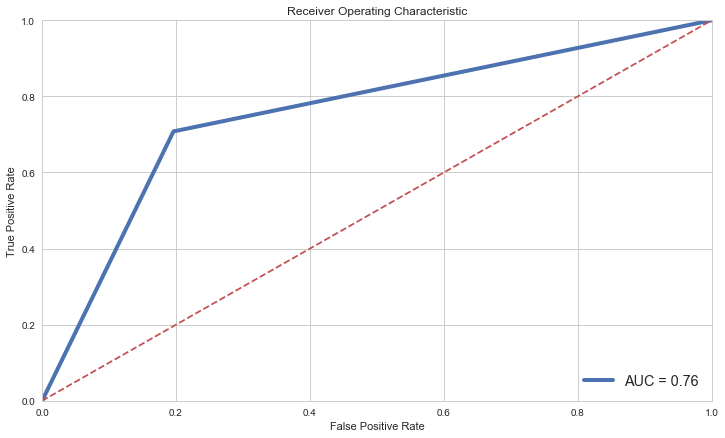

The sensitivity i.e true positives is 70.798898% 
The specificity i.e true negatives is 80.371353% 
The Type I error i.e. false negatives is 29.201102% 
The Type II error i.e. false positives is 19.628647% 


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
model(LogisticRegression(C=1e9, solver='liblinear'))

In [46]:
### Gradient Boost Classifier

Model train score is 0.99

Cross_validation scores below :
 [0.74666667 0.77333333 0.76       0.78378378 0.7972973  0.87837838
 0.7972973  0.79452055 0.7260274  0.80821918]

Mean/test accuracy: 0.79 (+/- 0.08)



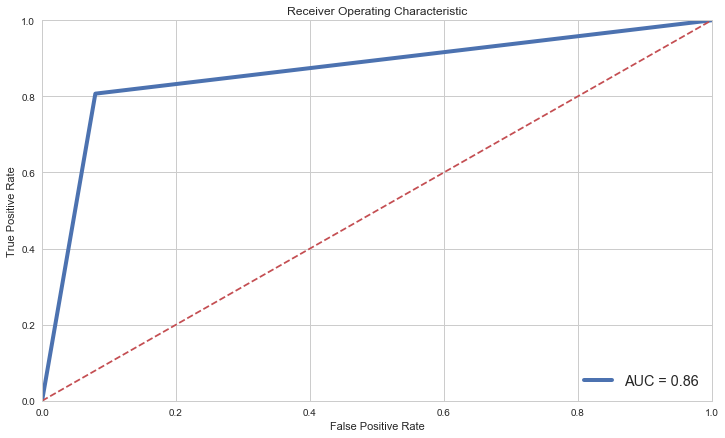

The sensitivity i.e true positives is 80.716253% 
The specificity i.e true negatives is 92.042440% 
The Type I error i.e. false negatives is 19.283747% 
The Type II error i.e. false positives is 7.957560% 


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
model(ensemble.GradientBoostingClassifier(**params))

The Gradient Boost classifier gives the best AUC of 0.86. percent 80% test accuracy and also low errors compared to other models.

### Word2Vec

In [48]:
len(all_reviews_list_cleaned_doc)

1856

In [49]:
# Cleaning the texts and making the reviews as a list of lists needed for word2vec.

all_reviews_list_cleaned_doc = []
all_reviews_positive_list_cleaned_doc = []
all_reviews_negative_list_cleaned_doc = []
temp=[]         
for review in all_reviews_positive_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and not token.is_stop and  token.is_alpha:
            temp.append(token.text.lower())
    all_reviews_positive_list_cleaned_doc.append(temp)
    temp=[]
        
for review in all_reviews_negative_list_doc:
    for token in review:
        if not token.is_punct and not token.is_space and not token.is_stop and  token.is_alpha:
            temp.append(token.text.lower())
    all_reviews_negative_list_cleaned_doc.append(temp)
    temp=[]
all_reviews_list_cleaned_doc = all_reviews_positive_list_cleaned_doc+all_reviews_negative_list_cleaned_doc

In [51]:
for item in all_reviews_list_cleaned_doc:
    print ((item))
    break

['saw', 'series', 'tv', 'imressed', 'second', 'time', 'story', 'line', 'moves', 'effortlessly', 'characters', 'intriguing', 'suspense', 'superb', 'highly', 'recommend', 'series', 'enjoy', 'horror', 'great', 'story', 'line', 'american', 'horror', 'story', 'good']


In [52]:
len(all_reviews_list_cleaned_doc)

1856

In [53]:
import gensim 
model = gensim.models.Word2Vec (all_reviews_list_cleaned_doc, size=10, window=5, min_count=2, workers=10)

model.train(all_reviews_list_cleaned_doc,total_examples=len(all_reviews_list_cleaned_doc),epochs=10)

(652219, 757740)

In [54]:
vocab=model.wv.vocab.keys()

In [55]:
print (type(vocab))

<class 'dict_keys'>


In [56]:

model.wv.most_similar (positive='cool')

[('sort', 0.9993503093719482),
 ('satisfying', 0.9991529583930969),
 ('wilson', 0.9991020560264587),
 ('intelligent', 0.9990094900131226),
 ('surprisingly', 0.9988892674446106),
 ('clever', 0.998873233795166),
 ('insightful', 0.9987607002258301),
 ('typical', 0.99870765209198),
 ('report', 0.9986562132835388),
 ('extremely', 0.9986466765403748)]

In [57]:
model['excellent']

/Users/Sri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.91171587,  1.956307  , -2.0876255 , -1.2192907 , -0.9276077 ,
       -0.69962287,  1.3873463 , -1.1240077 ,  0.60522383, -1.3595711 ],
      dtype=float32)

In [58]:
word2vec_df = pd.DataFrame()
for word in vocab:
    if word in 
    word2vec_df[word] = model[word]

SyntaxError: invalid syntax (<ipython-input-58-0c6390030d0b>, line 3)

In [ ]:
#from gensim.test.utils import common_texts
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_reviews_list_cleaned_doc)]
#model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [ ]:
#from gensim.test.utils import get_tmpfile

#fname = get_tmpfile("my_doc2vec_model")

#model.save(fname)
#model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

The model can be enhanced even more using sentence2vec or doc2vec embedding to generalize more.